In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
import warnings
warnings.filterwarnings("ignore")

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("blastchar/telco-customer-churn")


print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/telco-customer-churn


In [3]:
import pandas as pd
DATA_PATH = "/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(DATA_PATH)

print("Dataset shape:", df.shape)
print(df.head())


Dataset shape: (7043, 21)
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingM

In [4]:
DATA_PATH = "/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(DATA_PATH)

print("Dataset shape:", df.shape)
display(df.head())


Dataset shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
# Reload dataset fresh
DATA_PATH = "/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(DATA_PATH)

print("Original shape:", df.shape)

# Drop ID column safely
df.drop(columns=["customerID"], inplace=True)

# Fix TotalCharges
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Drop rows with missing TotalCharges (11 rows only)
df = df.dropna(subset=["TotalCharges"]).reset_index(drop=True)

# IMPORTANT: Handle Churn CORRECTLY (do NOT remap twice)
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

print("After cleaning shape:", df.shape)
print("Churn distribution:\n", df["Churn"].value_counts())


Original shape: (7043, 21)
After cleaning shape: (7032, 20)
Churn distribution:
 Churn
0    5163
1    1869
Name: count, dtype: int64


In [6]:
X = df.drop("Churn", axis=1)
y = df["Churn"]

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (7032, 19)
y shape: (7032,)


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Churn rate:", y.mean())


Train shape: (5625, 19)
Test shape: (1407, 19)
Churn rate: 0.26578498293515357


In [8]:
# Identify categorical & numerical columns from TRAIN set
cat_cols = X_train.select_dtypes(include="object").columns.tolist()
num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()

print("Categorical features:", cat_cols)
print("Numerical features:", num_cols)


Categorical features: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Numerical features: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


In [9]:
# Numeric - median
X_train[num_cols] = X_train[num_cols].fillna(X_train[num_cols].median())
X_test[num_cols]  = X_test[num_cols].fillna(X_train[num_cols].median())

# Categorical - 'Unknown'
X_train[cat_cols] = X_train[cat_cols].fillna("Unknown")
X_test[cat_cols]  = X_test[cat_cols].fillna("Unknown")

In [10]:
# Positive class weight (churn = 1)
pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print("scale_pos_weight:", pos_weight)

scale_pos_weight: 2.762541806020067


In [11]:
# Copy 1: For LightGBM (categorical as 'category')
X_train_lgb = X_train.copy()
X_test_lgb  = X_test.copy()
cat_cols = X_train.select_dtypes(include="object").columns.tolist()

for col in cat_cols:
    X_train_lgb[col] = X_train_lgb[col].astype("category")
    X_test_lgb[col]  = X_test_lgb[col].astype("category")

# Copy 2: For CatBoost (categorical as string/object)
X_train_cat = X_train.copy()
X_test_cat  = X_test.copy()

for col in cat_cols:
    X_train_cat[col] = X_train_cat[col].astype(str)
    X_test_cat[col]  = X_test_cat[col].astype(str)



In [12]:
# Numerical columns
num_cols = X_train_lgb.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Fill numeric
X_train_lgb[num_cols] = X_train_lgb[num_cols].fillna(X_train_lgb[num_cols].median())
X_test_lgb[num_cols]  = X_test_lgb[num_cols].fillna(X_train_lgb[num_cols].median())

X_train_cat[num_cols] = X_train_cat[num_cols].fillna(X_train_cat[num_cols].median())
X_test_cat[num_cols]  = X_test_cat[num_cols].fillna(X_train_cat[num_cols].median())


In [13]:
pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print("Positive class weight:", pos_weight)


Positive class weight: 2.762541806020067


In [14]:
import lightgbm as lgb

lgb_model = lgb.LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=pos_weight,
    random_state=42
)

lgb_model.fit(X_train_lgb, y_train)


[LightGBM] [Info] Number of positive: 1495, number of negative: 4130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 641
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265778 -> initscore=-1.016151
[LightGBM] [Info] Start training from score -1.016151


LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05, n_estimators=500,
               num_leaves=64, random_state=42,
               scale_pos_weight=2.762541806020067, subsample=0.8)

In [15]:
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=8,
    loss_function="Logloss",
    eval_metric="AUC",
    scale_pos_weight=pos_weight,
    verbose=False
)

cat_model.fit(
    X_train,
    y_train,
    cat_features=cat_cols
)


In [16]:
# Predict probabilities
lgb_prob = lgb_model.predict_proba(X_test_lgb)[:, 1]
cat_prob = cat_model.predict_proba(X_test_cat)[:, 1]

# Ensemble (weights can be tuned)
ensemble_prob = 0.6 * lgb_prob + 0.4 * cat_prob
ensemble_pred = (ensemble_prob >= 0.5).astype(int)


In [17]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    matthews_corrcoef
)

def print_metrics(model, X_test, y_test, model_name="Model"):
    # Probabilities and predictions
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)

    print(f"\n===== {model_name} Evaluation =====")
    print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall   : {recall_score(y_test, y_pred):.4f}")
    print(f"F1-score : {f1_score(y_test, y_pred):.4f}")
    print(f"ROC-AUC  : {roc_auc_score(y_test, y_prob):.4f}")
    print(f"PR-AUC   : {average_precision_score(y_test, y_prob):.4f}")
    print(f"MCC      : {matthews_corrcoef(y_test, y_pred):.4f}")


print_metrics(lgb_model, X_test_lgb, y_test, "LightGBM")
print_metrics(cat_model, X_test_cat, y_test, "CatBoost")



===== LightGBM Evaluation =====
Accuracy : 0.7555
Precision: 0.5342
Recall   : 0.6257
F1-score : 0.5764
ROC-AUC  : 0.8109
PR-AUC   : 0.6021
MCC      : 0.4085

===== CatBoost Evaluation =====
Accuracy : 0.7505
Precision: 0.5216
Recall   : 0.7433
F1-score : 0.6130
ROC-AUC  : 0.8246
PR-AUC   : 0.6350
MCC      : 0.4521


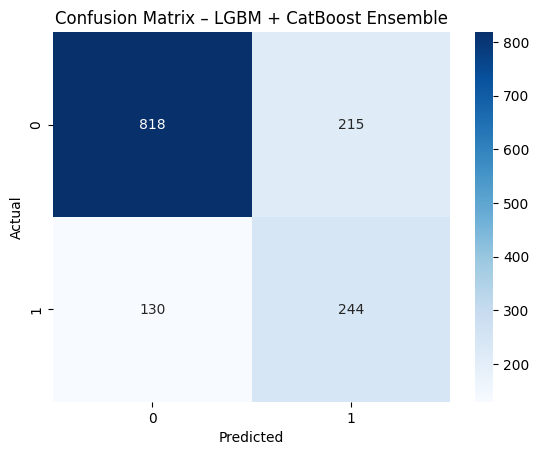

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, ensemble_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – LGBM + CatBoost Ensemble")
plt.show()



In [19]:
def ks_statistic(y_true, y_prob):
    data = pd.DataFrame({"y": y_true, "prob": y_prob}).sort_values("prob", ascending=False)
    data["cum_pos"] = data["y"].cumsum() / data["y"].sum()
    data["cum_neg"] = ((1 - data["y"]).cumsum()) / (1 - data["y"]).sum()
    return np.max(np.abs(data["cum_pos"] - data["cum_neg"]))

ks = ks_statistic(y_test, ensemble_prob)
print(f"KS Statistic: {ks:.3f}")


KS Statistic: 0.512


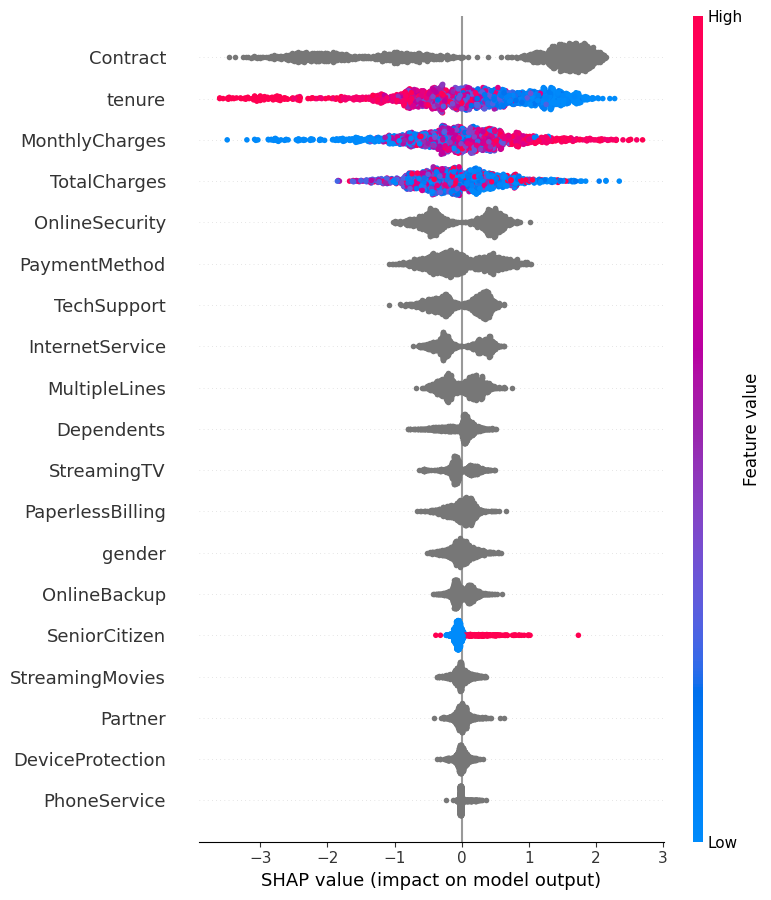

In [20]:
import shap

# Use the SAME data format used for training LightGBM
explainer = shap.TreeExplainer(lgb_model)

shap_values = explainer.shap_values(X_test_lgb)

# For binary classification, shap_values may be a list
if isinstance(shap_values, list):
    shap_values = shap_values[1]  # class = 1 (churn)

shap.summary_plot(shap_values, X_test_lgb)
